# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. Новая функциональность позволяет быстро узнать рыночную стоимость своего автомобиля. 
Исходные данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Метрики:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Импорты и подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from catboost import CatBoostRegressor, CatBoostRegressor
from sklearn.preprocessing import OrdinalEncoder, normalize, StandardScaler 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, confusion_matrix
from lightgbm import LGBMRegressor
import timeit
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv('/datasets/autos.csv')
data = data.drop_duplicates().reset_index(drop=True)


display(data.head(5))
display(data.describe())
# display(data.info())


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [3]:
#Здесь мы боремся с выбросами
min_q_year = data['RegistrationYear'].quantile(q=0.0005)
max_q_year = data['RegistrationYear'].quantile(q=0.9859)
data = data[(data['RegistrationYear'] > min_q_year) & (data['RegistrationYear'] < max_q_year)]




min_q_price = data['Price'].quantile(q=0.005)
max_q_price = data['Price'].quantile(q=0.9859)
data = data[(data['Price'] > min_q_price) & (data['Price'] < max_q_price)]



min_q_power = data['Power'].quantile(q=0.005)
max_q_power = data['Power'].quantile(q=0.9859)
data = data[(data['Power'] > min_q_power) & (data['Power'] < max_q_power)]


print(data.describe())

               Price  RegistrationYear          Power      Kilometer  \
count  286790.000000     286790.000000  286790.000000  286790.000000   
mean     4522.512950       2002.724394     116.052056  128829.056104   
std      4188.170553          6.459680      46.159847   36281.564642   
min         1.000000       1930.000000       1.000000    5000.000000   
25%      1300.000000       1999.000000      75.000000  125000.000000   
50%      2999.000000       2003.000000     109.000000  150000.000000   
75%      6550.000000       2007.000000     143.000000  150000.000000   
max     17999.000000       2016.000000     271.000000  150000.000000   

       RegistrationMonth  NumberOfPictures     PostalCode  
count      286790.000000          286790.0  286790.000000  
mean            5.983821               0.0   51163.622968  
std             3.587220               0.0   25777.506074  
min             0.000000               0.0    1067.000000  
25%             3.000000               0.0   30900.

Были обнаружены выбросы или ошибочные даннные с мощностью 20000, и регистрацией тс в 9999 году, путем отбрасывания 0.005 и 0.999 процентилей мы избавились от этих выбросов.

In [4]:
# data.groupby('NotRepaired')['NotRepaired'].count().plot(kind='bar') # Большинство у нас не битых,  заменим NaN на 'no'
# data.groupby('VehicleType')['VehicleType'].count().plot(kind='bar') # Большинство седанов и малолитражек,  заменим NaN на 'sedan'
# data.groupby('FuelType')['FuelType'].count().plot(kind='bar') # Заменим на бензин
# data.groupby('Gearbox')['Gearbox'].count().plot(kind='bar') # Заменим на manual

# data['Price'].plot(kind='hist', bins=500)
# data['RegistrationYear'].plot(kind='hist', bins=50)

In [5]:
data_ml = data.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures',  'LastSeen'], axis=1)

data_ml['PostalCode'] = data_ml['PostalCode'].astype(str)
data_ml['PostalCode'] = data_ml['PostalCode'].str[0:2]#.astype(int)
print(data_ml['PostalCode'])


# print(data_ml.info())

2         90
3         91
4         60
5         33
6         67
          ..
354357    51
354358    96
354362    26
354363    87
354364    40
Name: PostalCode, Length: 286790, dtype: object


Оставляем первые 2 цифры индекса для более крупной группировки признака

In [6]:
data_ml_new = data_ml.dropna(axis=0).reset_index(drop=True) #В эттой выборке выброшены все пропущенные значения



data_ml_new['PostalCode'] = data_ml_new['PostalCode'].astype(str)
data_ml_new['PostalCode'] = data_ml_new['PostalCode'].str[0:2]#.astype(int)

Из первоначального датафрейма были удалены все выбросы, дубликаты, также подготовлены  2 датафрема, с заменами, и с удалением всех строк, содержащих пропуски.






# Обучение моделей

In [7]:
cat_features = ['VehicleType', 'FuelType', 'Brand', 'Gearbox', 'NotRepaired', 'Model', 'PostalCode']

def variants(data_def): 
    features_train, features_valid, target_train, target_valid = train_test_split(data_def.drop('Price', axis=1), 
                                                                                  data_def['Price'], 
                                                                                  test_size=0.25, random_state=12345 )
    return features_train, features_valid, target_train, target_valid



In [8]:
def normalize_data(features_train, features_valid):
    string = ['RegistrationYear', 'Power', 'Kilometer']
    features_train[string] = normalize(features_train[string])
    features_valid[string] = normalize(features_valid[string])
    
    

#     data_norm = normalize(data_new)
#     data_norm = pd.DataFrame(data_norm, index=data_new.index, columns=data_new.columns)
    return features_train, features_valid


In [9]:
def encoder_str(features_train, features_valid):
    string = ['VehicleType', 'FuelType', 'Brand', 'Gearbox', 'NotRepaired', 'Model', 'PostalCode']
    encoder = OrdinalEncoder() 
#     pd.options.mode.chained_assignment = None #ЧТО ДЕЛАЕТ ЭТА СТРОКА?
    encoder.fit(features_train[string]) 
    features_train[string] = encoder.transform(features_train[string])
    features_valid[string] = encoder.transform(features_valid[string]) 

    return features_train, features_valid


In [10]:
def standart_data_num(features_train, features_valid):
    numeric = ['RegistrationYear', 'Power', 'Kilometer']
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    pd.options.mode.chained_assignment = None
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric]) 
    return features_train, features_valid


In [11]:
features_cv = data_ml_new.drop('Price', axis=1)
target_cv = data_ml['Price']
# 

In [12]:
#LinearRegression_ml
def LR(features_train, features_valid, target_train, target_valid):
    start_time = timeit.default_timer()
    model_lr = LinearRegression()
    model_lr.fit(features_train, target_train)
    speed_fit = timeit.default_timer() - start_time
    
    
    start_time = timeit.default_timer()
    pred_valid_lr = model_lr.predict(features_valid)
    speed_pred = timeit.default_timer() - start_time
    rmse_lr = mean_squared_error(target_valid, pred_valid_lr)**0.5
    
    print('Время обучения:', speed_fit)
    print('Время предсказания:', speed_pred)
    print('RMSE:', rmse_lr)
    return ['LR', speed_fit, speed_pred, rmse_lr]

In [13]:
features_train, features_valid, target_train, target_valid = variants(data_ml_new)
features_train, features_valid = encoder_str(features_train, features_valid)
# print(features_train)

In [14]:
LR(features_train, features_valid, target_train, target_valid)

Время обучения: 0.07465476309880614
Время предсказания: 0.15384302800521255
RMSE: 2670.1325826348734


['LR', 0.07465476309880614, 0.15384302800521255, 2670.1325826348734]

In [15]:
features_train, features_valid, target_train, target_valid = variants(data_ml_new)
features_train, features_valid = encoder_str(features_train, features_valid)
# features_train, features_valid = normalize_data(features_train, features_valid)
features_train, features_valid = standart_data_num(features_train, features_valid)




In [16]:

rmse_lr = LR( features_train, features_valid, target_train, target_valid)

Время обучения: 0.06805922370404005
Время предсказания: 0.005734828766435385
RMSE: 2670.132582634873


********************************

In [17]:

#RandomForestRegressor
def RFR(features_train, features_valid, target_train, target_valid):
    best_depth = 0
    best_estimators = 0
    best_rmse = 10000
    time_fit = 0
    time_pred = 0
    best_model = None
    for depth in range(1, 5):
        for est in range(0,20,10):
            start_time = timeit.default_timer()
            model_rfr = RandomForestRegressor(random_state=12345, max_depth=10, n_estimators=50)
            model_rfr.fit(features_train, target_train)
            speed_fit = timeit.default_timer() - start_time
            
            start_time = timeit.default_timer()
            pred_valid_rfr = model_rfr.predict(features_valid)
            rmse_rfr = mean_squared_error(target_valid, pred_valid_rfr)**0.5
            speed_pred = timeit.default_timer() - start_time
            
            if rmse_rfr < best_rmse:
                best_depth = depth
                best_estimators = est
                best_rmse = rmse_rfr
                time_fit = speed_fit
                time_pred = speed_pred
                best_model = model_rfr
    
#     print('Время обучения:', time_fit)
#     print('Время предсказания:', time_pred)
#     print('RMSE:', best_rmse)
    return ['RFR', speed_fit, speed_pred, best_rmse]

In [18]:
features_train, features_valid, target_train, target_valid = variants(data_ml_new)
features_train, features_valid = encoder_str(features_train, features_valid)
features_train, features_valid = standart_data_num(features_train, features_valid)

rmse_rfr = RFR( features_train, features_valid, target_train, target_valid)

In [19]:
# features_train, features_valid, target_train, target_valid = variants(normalize_data(encoder(data_ml_new)))
# RFR(features_train, features_valid, target_train, target_valid)

In [20]:
#CATBOOST
data_ct = data_ml.fillna('NaN')

def CB(features_train, features_valid, target_train, target_valid):
    start_time = timeit.default_timer()
    model_cb = CatBoostRegressor(loss_function='RMSE', iterations=500, depth=5, learning_rate=1 )
    model_cb.fit(features_train, target_train, cat_features=cat_features, verbose=1000)
    speed_fit = timeit.default_timer() - start_time
    
    start_time = timeit.default_timer()
    pred_valid = model_cb.predict(features_valid) 
    rmse = mean_squared_error(target_valid, pred_valid)**0.5
    speed_pred = timeit.default_timer() - start_time
    
#     print('Время обучения:', speed_fit)
#     print('Время предсказания:', speed_pred)
#     print('RMSE:', rmse)
    return ['CB', speed_fit, speed_pred, rmse]

In [21]:
# features_train, features_valid, target_train, target_valid = variants(data_ml_rp)
# CB(features_train, features_valid, target_train, target_valid)

In [22]:
features_train, features_valid, target_train, target_valid = variants(data_ct)
rmse_cb = CB(features_train, features_valid, target_train, target_valid)

0:	learn: 2524.7967716	total: 914ms	remaining: 7m 36s
499:	learn: 1369.8390486	total: 6m 24s	remaining: 0us


In [23]:
rmse_cb

['CB', 390.9089041752741, 1.1387075260281563, 1482.4371555864511]

In [25]:
# features_train, features_valid, target_train, target_valid = variants(normalize_data(encoder(data_ml_new)))
# CB(features_train, features_valid, target_train, target_valid)

In [27]:
#LGBMRegressor

def LGBM (features_train, features_valid, target_train, target_valid):
#     cat_features = ['VehicleType', 'Gearbox',  'Model', 'FuelType', 'Brand',  'NotRepaired', 'PostalCode']
    start_time = timeit.default_timer()
    model_lgbm = LGBMRegressor(max_depth=14, 
                            n_estimators=120, 
                            random_state=12345, 
                            objective='regression',
                            num_leaves=1400,
                            metric='rmse')
    model_lgbm.fit(features_train, target_train, verbose=10)
    speed_fit = timeit.default_timer() - start_time
    
    
    start_time = timeit.default_timer()
    predictions_lgbm = model_lgbm.predict(features_valid,  num_iteration=2)
    rmse_lgbm = mean_squared_error(target_valid, predictions_lgbm)**0.5
    speed_pred = timeit.default_timer() - start_time
    
#     print('Время обучения:', speed_fit)
#     print('Время предсказания:', speed_pred)
#     print('RMSE:', rmse_lgbm)
    return ['LGBM',speed_fit, speed_pred, rmse_lgbm]

In [29]:
data_ct = data_ml.fillna('NaN')
features_train, features_valid, target_train, target_valid = variants(data_ct)
features_train, features_valid = encoder_str(features_train, features_valid)

rmse_lgbm = LGBM(features_train, features_valid, target_train, target_valid)

# Анализ моделей

Так как данные имеют разный масштаб и есть категориальные признаки, перед началом обучения моделей производим кодирование и нормализацию.
Самая низкая(качественная) метрика RMSE на одних и тех же моделей у моделей, которым были переданные стандартизированные данные, из датафрейма без заполнения пропусков (были удалены все строки со значением nan). Заполнение пропусков снижает качество модели. 
Среди моделей линейной регрессии, случайного леса регрессии, градиентного бустинга CatBoost и градиентного бустинга LGBMRegressor, наилучшее качество у случайного леса NRMSE =  0.023, скорость обучения = 71 секунда, а скорость предсказания = 0.23сек. При этом третья по качеству предсказаний линейная модель обучается за 0.067 секунды и имеет показатель NRMSE=0.16, что в несколько десятков раз больше чем у случайного леса, но при этом обучается она более чем в 1000 раз быстрее. Скорость предсказания у линейной регрессии в 70 раз выше чем у случайного леса. 
Модель градиентного LGBMRegressor по скорости обучения  в 3 раза быстрее случайного леса, а показатель NRMSE больше(хуже) в 2 раза, при этом скорость предсказания меньше на треть. 



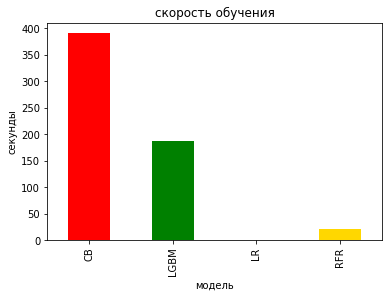

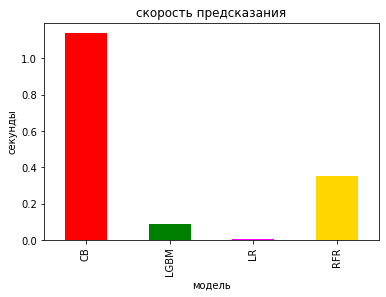

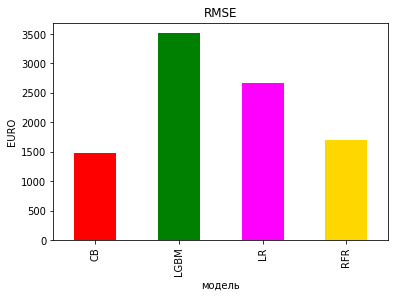

               RMSE  скорость обучения  скорость предсказания
модель                                                       
CB      1482.437156         390.908904               1.138708
LGBM    3517.332440         186.786907               0.086013
LR      2670.132583           0.068059               0.005735
RFR     1703.548918          20.922135               0.349696


In [31]:
rmse_all = [rmse_lr,
            rmse_rfr,
            rmse_cb,
            rmse_lgbm]
# print(rmse_all)
rmse_columns = ['модель', 'скорость обучения', 'скорость предсказания','RMSE']
rmse_pivot = pd.DataFrame(rmse_all, columns=rmse_columns).pivot_table(index='модель', values=['скорость обучения', 'скорость предсказания','RMSE'],
                                                                     aggfunc='sum')


colors = ["red", "green", "magenta", "gold"]

rmse_pivot['скорость обучения'].plot(kind='bar', title='скорость обучения', color=colors)
plt.ylabel('секунды')
plt.show()


rmse_pivot['скорость предсказания'].plot(kind='bar', title='скорость предсказания', color=colors)
plt.ylabel('секунды')
plt.show()


rmse_pivot['RMSE'].plot( kind='bar', title='RMSE', color=colors )
plt.ylabel('EURO')
plt.show()

print(rmse_pivot)


In [33]:
features_train, features_valid, target_train, target_valid = variants(data_ml_new)

features_train, features_valid = encoder_str(features_train, features_valid)
features_train, features_valid = standart_data_num(features_train, features_valid)

def RFR(features_train, features_valid, target_train, target_valid):
    best_depth = 0
    best_estimators = 0
    best_rmse = 10000
    time_fit = 0
    time_pred = 0
    best_model = None
    for depth in range(1, 5):
        for est in range(0,20,10):
            start_time = timeit.default_timer()
            model_rfr = RandomForestRegressor(random_state=12345, max_depth=10, n_estimators=50)
            model_rfr.fit(features_train, target_train)
            speed_fit = timeit.default_timer() - start_time
            
            start_time = timeit.default_timer()
            pred_valid_rfr = model_rfr.predict(features_valid)
            rmse_rfr = mean_squared_error(target_valid, pred_valid_rfr)**0.5
            speed_pred = timeit.default_timer() - start_time
            
            if rmse_rfr < best_rmse:
                best_depth = depth
                best_estimators = est
                best_rmse = rmse_rfr
                time_fit = speed_fit
                time_pred = speed_pred
                best_model = model_rfr
    

    return best_model
best_model = RFR(features_train, features_valid, target_train, target_valid)

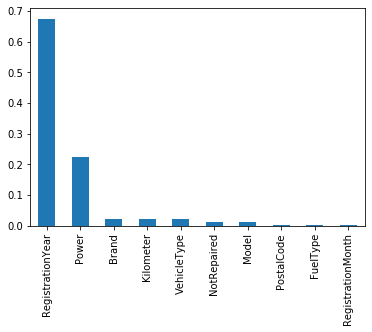

In [35]:
#Заготовка для диаграммы важностей признаков.

feat_importances = pd.Series(best_model.feature_importances_, index=features_train.columns)
feat_importances.nlargest(10).plot(kind='bar')

# Вывод 
Быстрее всех обучается модель линейной регрессии, при этом ее отклонения равно примерно 2670 евро, самая неточная модель - LGBM, у нее показатель rmse +-3517, при этом обучается она 52 секунду - это третий результат по скорости. Модель CatBoost показала самое большое время обучения но самое меньшее отклонение d 1482. Дерево решений обучается 16 секунд, при этом RMSE у нее 1703 (евро). Наибольшее влияние на цену имеет год выпуска, второй по важности критерий - мощность, остальные признаки более чем 10 раз менее значимы чем вышеперечисленные.


